In [1]:
%load_ext autoreload
%autoreload #Use this to reload modules if they are changed on disk while the notebook is running
from __future__ import division
from snmachine import sndata, snfeatures, snclassifier, tsne_plot
import numpy as np
import matplotlib.pyplot as plt
import time, os, pywt,subprocess
from sklearn.decomposition import PCA
from astropy.table import Table,join,vstack
from astropy.io import fits
import sklearn.metrics 
import sncosmo
%matplotlib nbagg
from astropy.table import Column

Neural networks not available in this version of scikit-learn. Neural networks are available from development version 0.18.


## SN numbers with classification code
SN001695   - 2

2457 - 33

2542 - 1

5399 - 2

13481 - 2

13866 - 1 

16742 - 21

17270 - 32

27266 -32

64968 - 23

149147 -21

In [2]:
dataset='spcc'

In [3]:
# WARNING...
#Multinest uses a hardcoded character limit for the output file names. I believe it's a limit of 100 characters
#so avoid making this file path to lengthy if using nested sampling or multinest output file names will be truncated

#Change outdir to somewhere on your computer if you like
outdir=os.path.join('output_%s_no_z' %dataset,'')
out_features=os.path.join(outdir,'features') #Where we save the extracted features to
out_class=os.path.join(outdir,'classifications') #Where we save the classification probabilities and ROC curves
out_int=os.path.join(outdir,'int') #Any intermediate files (such as multinest chains or GP fits)

subprocess.call(['mkdir',outdir])
subprocess.call(['mkdir',out_features])
subprocess.call(['mkdir',out_class])
subprocess.call(['mkdir',out_int])

1

In [4]:
#Data root
rt=os.path.join('SPCC_SUBSET','')

In [5]:
dat=sndata.Dataset(rt)

Reading data...
11 objects read into memory.


In [6]:
read_from_file=False #True #We can use this flag to quickly rerun from saved features
run_name=os.path.join(out_features,'%s_all' %dataset)

In [7]:
dat.object_names[0]
types=dat.get_types()
types['Type'][np.floor(types['Type']/10)==2]=2
types['Type'][np.floor(types['Type']/10)==3]=3

<IPython.core.display.Javascript object>


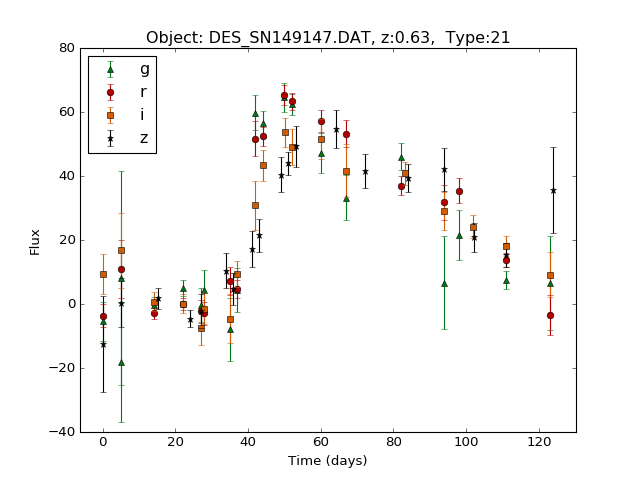

mjd,filter,flux,flux_error,zp,zpsys
float64,str4,float64,float64,float64,str2
0.0,desg,3.874,4.787,27.5,ab
0.0160000000033,desr,-5.456,5.335,27.5,ab
0.0310000000027,desi,-10.3,5.439,27.5,ab
0.0619999999981,desz,1.439,4.691,27.5,ab
2.0,desg,-0.7297,2.238,27.5,ab
2.14,desr,-2.837,3.03,27.5,ab
2.156,desi,-4.236,4.2,27.5,ab
2.187,desz,-5.086,3.518,27.5,ab
9.984,desg,0.03404,1.702,27.5,ab


In [8]:
#test_table = dat.data['DES_SN001695.DAT'] #get_lightcurve

dat.plot_all()
dat.data[dat.object_names[0]]

In [11]:
type_II = []
for i in range(len(dat.data['DES_SN002457.DAT']['flux'])):
    type_II.append(np.random.normal(dat.data['DES_SN002457.DAT']['flux'][i], dat.data['DES_SN002457.DAT']['flux_error'][i], 5))

In [12]:
type_Ia = []
for i in range(len(dat.data['DES_SN002542.DAT']['flux'])):
    type_Ia.append(np.random.normal(dat.data['DES_SN002542.DAT']['flux'][i], dat.data['DES_SN002542.DAT']['flux_error'][i], 5))

In [13]:
type_Ibc = []
for i in range(len(dat.data['DES_SN005399.DAT']['flux'])):
    type_Ibc.append(np.random.normal(dat.data['DES_SN005399.DAT']['flux'][i], dat.data['DES_SN005399.DAT']['flux_error'][i], 5))

In [14]:
type_Ia = np.array(type_Ia)
type_Ibc = np.array(type_Ibc)
type_II = np.array(type_II)

In [15]:
#test_table.replace_column('flux', type_II[:,0])

In [16]:
#test_table.write('testing.dat',format = 'ascii')

In [17]:
#dat.data['DES_SN001695.DAT']
#print type_Ia

In [18]:
#isinstance(dat.object_names, np.ndarray)

In [19]:
#test_table_II = dat.data['DES_SN002457.DAT']

In [20]:
#dir(dat)

In [21]:
#print data[0:10]
#print data[5].split()
def make_new_data(filename, table, output):
    with open(filename) as f:
        data = f.read().split("\n")
    filters = data[5].split()
    survey = data[0].split()
    stuffRA = data[6].split()
    stuffDec = data[7].split()
    MWEBV = data[11].split()
    table.meta = {survey[0][:-1]: survey[1], stuffRA[0][:-1]: stuffRA[1], stuffDec[0][:-1]: stuffDec[1],filters[0][:-1]: filters[1],
                 MWEBV[0][:-1]: MWEBV[1]}
    #table.rename_column('mjd', 'MJD')
    #table.rename_column('filter ', 'FLT')
    #table.rename_column('flux', 'FLUXCAL')
    #table.rename_column('flux_error', 'FLUXCALERR')
    sncosmo.write_lc(table, 'new_mocks/%s.dat'%output,pedantic=True, format = 'snana')

In [22]:
filename_II = 'SPCC_SUBSET/DES_SN002457.DAT'
filename_Ia = 'SPCC_SUBSET/DES_SN002542.DAT'
filename_Ibc = 'SPCC_SUBSET/DES_SN005399.DAT'

test_table_II = dat.data['DES_SN002457.DAT']
test_table_Ia = dat.data['DES_SN002542.DAT']
test_table_Ibc = dat.data['DES_SN005399.DAT']
#print test_table_II

#test_table_Ia.replace_column('mjd', test_table_Ia['mjd']+56178)
#test_table_II.replace_column('mjd', test_table_II['mjd']+56178)
#test_table_Ibc.replace_column('mjd', test_table_Ibc['mjd']+56178)

test_table_II.rename_column('flux', 'FLUXCAL')
test_table_II.rename_column('flux_error', 'FLUXCALERR')
    
test_table_Ibc.rename_column('flux', 'FLUXCAL')
test_table_Ibc.rename_column('flux_error', 'FLUXCALERR')
    
test_table_Ia.rename_column('flux', 'FLUXCAL')
test_table_Ia.rename_column('flux_error', 'FLUXCALERR')

objs=[]
new_data={}

for i in range(5):
    test_table_Ia.replace_column('FLUXCAL', type_Ia[:,i])
    test_table_Ibc.replace_column('FLUXCAL', type_Ibc[:,i])
    test_table_II.replace_column('FLUXCAL', type_II[:,i])
    
    make_new_data(filename_Ibc, test_table_Ibc, 'Ibc_%s'%i)
    make_new_data(filename_II, test_table_II, 'II_%s'%i)
    make_new_data(filename_Ia, test_table_Ia, 'Ia_%s'%i)
    
    #objs.append((str)(i))
    new_data[(str)(i)]=test_table_II.copy()  #new_light_curve_Ia
    new_data[(str)(i+5)]=test_table_Ia.copy()#new_light_curve_II
    new_data[(str)(i+10)]=test_table_Ibc.copy()#new_light_curve_Ibc
    
#sncosmo.read_lc(new_data)
#new_data = Counter(new_data_Ia) + Counter(new_data_II) + Counter(new_data_Ibc)

for i in range(15):    
    objs.append((str)(i))
    
dat.object_names=np.asarray(objs)
dat.data=new_data

In [23]:
rt1=os.path.join('new_mocks','')
dat1=sndata.Dataset(rt1)

Reading data...
15 objects read into memory.


In [24]:
for obj in dat1.object_names:
    for i in range(len(dat1.data[obj])):
        dat1.data[obj]['filter'][i]=dat1.data[obj]['filter'][i][3:7]

In [25]:
print dat1.data['Ia_4.dat']['filter']

filter
------
  desg
  desr
  desi
  desz
  desg
  desr
  desi
  desz
  desg
  desr
   ...
  desg
  desr
  desi
  desz
  desg
  desr
  desi
  desz
  desg
  desr
  desi
Length = 125 rows


In [26]:
#For now we restrict ourselves to three supernova types: Ia (1), II (2) and Ibc (3)
types=dat.get_types()
types['Type'][np.floor(types['Type']/10)==2]=2
types['Type'][np.floor(types['Type']/10)==3]=3

KeyError: 'type'

<IPython.core.display.Javascript object>


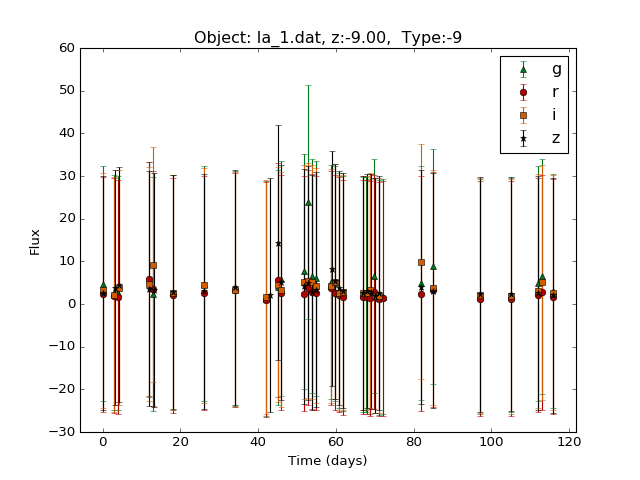

mjd,filter,flux,flux_error,zp,zpsys
float64,str7,float64,float64,float64,str2
0.0,desg,10.48,27.5,27.5,ab
0.0160000000033,desr,7.845,27.5,27.5,ab
0.0320000000065,desi,9.314,27.5,27.5,ab
0.977000000006,desz,5.328,27.5,27.5,ab
1.985,desg,3.205,27.5,27.5,ab
2.0,desr,2.425,27.5,27.5,ab
2.016,desi,4.31,27.5,27.5,ab
9.957,desz,27.32,27.5,27.5,ab
10.106,desg,25.57,27.5,27.5,ab


In [27]:
dat1.plot_all()
dat1.data[dat1.object_names[0]]

In [ ]:
dat1.data

In [ ]:
mod1Feats=snfeatures.ParametricFeatures('karpenka',sampler='leastsq')

In [ ]:
%%capture --no-stdout
if read_from_file:
    mod1_features=Table.read('%s_karpenka.dat' %run_name, format='ascii')
    blah=mod1_features['Object'].astype(str)
    mod1_features.replace_column('Object', blah)
else:
    mod1_features=mod1Feats.extract_features(dat1,nprocesses=4,chain_directory=out_int)
    mod1_features.write('%s_karpenka.dat' %run_name, format='ascii')

In [ ]:
print dat1.data

In [ ]:
#Unfortunately, sometimes the fitting methods return NaN for some parameters for these models.
for c in mod1_features.colnames[1:]:
    mod1_features[c][np.isnan(mod1_features[c])]=0
    
print mod1_features

In [ ]:
mod1Feats.fit_sn
dat1.set_model(mod1Feats.fit_sn,mod1_features)

In [ ]:
np.sort(dat.object_names)

In [ ]:
dat.set_model(waveFeats.fit_sn,wave_features,PCA_vec,PCA_mean,0,dat.get_max_length(),dat.filter_set)

In [ ]:
#dat.plot_all()

In [ ]:
#wave_features

In [ ]:
#types

In [ ]:
#join(wave_features, types)

In [ ]:
#plt.figure()
#tsne_plot.plot(wave_features,join(wave_features,types)['Type'])

In [ ]:
#This code takes the fitted parameters and generates the model light curve for plotting purposes.
#dat.set_model(salt2Feats.fit_sn,salt2_features)

In [ ]:
#dat.plot_all()

In [ ]:
#dat.data[dat.object_names[5]]